<h1>Visualizing Convnets with Tensorflow</h1>

아래 내용은 [github 저장소](https://github.com/wagonhelm/Visualizing-Convnets) 내용을 활용한 내용이다.

주요 내용은 ConvNet을 지날 때 이미지가 어떤 식으로 변하는지, filter가 이미지를 내부적으로 어떻게 변화시키는 지 확인하기 위함이다.


In [12]:
import imFunctions as imf
import tensorflow as tf
import scipy.ndimage
from scipy.misc import imsave
import matplotlib.pyplot as plt
import numpy as np

`imFunctions` 모듈 내 코드를 이용해서 필요한 이미지를 다운받는다.

In [4]:
imf.downloadImages('annotations.tar.gz', 19173078)
imf.downloadImages('images.tar.gz', 791918971)
imf.maybeExtract('annotations.tar.gz')
imf.maybeExtract('images.tar.gz')

File 'annotations.tar.gz' allready downloaded :)
File 'images.tar.gz' allready downloaded :)
annotations already present - Skipping extraction of annotations.tar.gz
images already present - Skipping extraction of images.tar.gz


test 데이터로 사용할 percentage를 정해준다.

In [5]:
imf.sortImages(0.15)

Images allready sorted


train, test 데이터 셋을 불러오는 함수이다. 데이터 선택 창이 뜰 건데 2개만 선택해서 진행하도록 하자.

In [6]:
train_x, train_y, test_x, test_y, classes, classLabels = imf.buildDataset()

Do you want to use Sphynx in your dataset?  [y/n/break]y
Do you want to use samoyed in your dataset?  [y/n/break]y
Do you want to use MaineCoon in your dataset?  [y/n/break]break
Sphynx = [[ 1.  0.]]
samoyed = [[ 0.  1.]]
Total Train Size: 340  Total Test Size: 60  Total # Classes 2


어떤 이미지가 있는지 확인하기 위해 1개만 띄워보자.

In [15]:
image = train_x[202]
scipy.misc.imshow(image)

filter의 역할을 알기 위해서 7x7 filter를 4개 만들어서 이미지를 어떤 식으로 표현하는지 확인해보자.

우리가 사용할 filter는 전체가 0으로 채워져있고 일부만 1인 값으로 채워진 것들을 사용할 것이다. 이 경우에 0인 곳과 만나는 이미지는 정보가 전달되지 않을 것이고 1인 곳과 만나는 이미지만 전달될 것이다. 이미지의 channel은 1이 될 것이고(*RGB가 아니고 흑/백이므로*) 
4개를 한 번에 적용시키기 위해서 out_channel의 크기는 4가 될 것이다. 

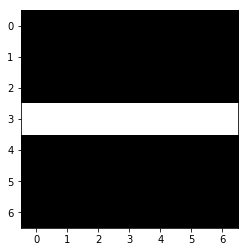

In [38]:
# filter를 4개 만든다. [height, width, in_channels, out_channels]
filters = np.zeros([7,7,1,4])

# 1번째 filter 수정
filters[3,:,0,0] = 1
plt.imshow(filters[:,:,:,0].reshape(7,7), cmap='gray')
plt.show()

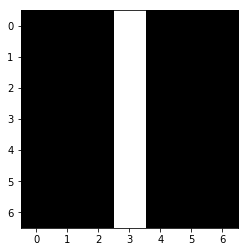

In [39]:
# 1번째 filter 수정
filters[:,3,0,1] = 1
plt.imshow(filters[:,:,:,1].reshape(7,7), cmap='gray')
plt.show()

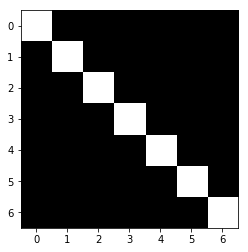

In [40]:
# 1번째 filter 수정
filters[:,:,0,2] = np.eye(7,7)
plt.imshow(filters[:,:,:,2].reshape(7,7), cmap='gray')
plt.show()

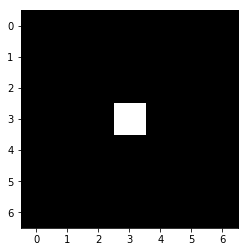

In [41]:
# 1번째 filter 수정
filters[:,:,:,3] -= 1
filters[3,3,:,3] = 8
plt.imshow(filters[:,:,:,3].reshape(7,7), cmap='gray')
plt.show()

이제 이미지를 grayscale로 만들어야 한다. 현재 RGB를 사용하니까 전체 값에 대한 평균을 낸 뒤 grayscale로 사용하면 된다. (*정확한 RGB, grayscale에 대한 이미지 표현 범위는 잘 모르겠다*)

In [57]:
# 이미지를 gray로 만들어주기 위해서 마지막 4 channel을 평균낸다. 
gray = np.mean(image,-1)

# CNN 구현하는 코드 
X = tf.placeholder(tf.float32, shape=(None, 224, 224, 1))
conv = tf.nn.conv2d(X, filters, [1,1,1,1], padding="SAME")
test = tf.Session()
test.run(tf.global_variables_initializer())
filteredImage = test.run(conv, feed_dict={X: gray.reshape(1,224,224,1)})
tf.reset_default_graph()

gray를 4d-tensor로 만들고 tensorflow를 이용해서 위에서 정의한 filter에 돌린 뒤 각 filter가 어떤 역할을 하는지 살펴보자.

filter가 어떤 역할은 하는지에 대한 직관이 생각이 안나서 이 사이트를 http://setosa.io/ev/image-kernels/ 보면서 이해하도록 하자.

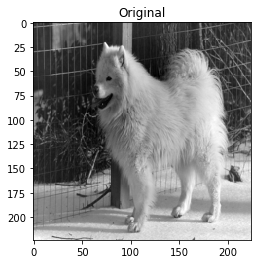

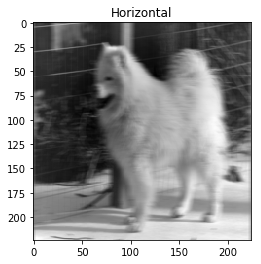

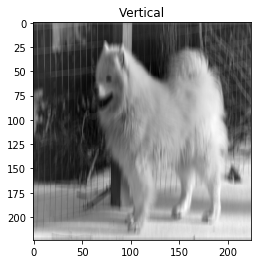

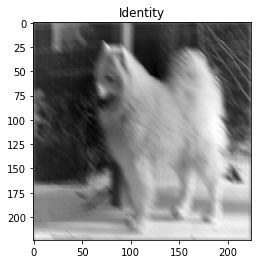

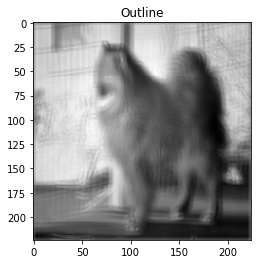

In [43]:
plt.imshow(gray, cmap='gray')
plt.title('Original')
plt.show()
labels = ['Horizontal', 'Vertical', 'Identity', 'Outline']
for i in range(4):
    plt.title(labels[i])
    plt.imshow(filteredImage[:,:,:,i].reshape(224,224),cmap = 'gray')
    plt.show()

filter에 따라서 layer를 통과한 이미지가 바뀌는 것을 볼 수 있다!

이제 CNN을 설계한 뒤에 학습시켜보도록 하자. 그 다음에 각 layer를 통과할 때의 이미지의 모습을 살펴보자. 

In [58]:
# input 데이터 placeholder
X = tf.placeholder(tf.float32, shape=(None, 224, 224, 3))
Y_ = tf.placeholder(tf.float32, [None, classes])
# dropout rate를 받는 placeholder
keepRate1 = tf.placeholder(tf.float32)
keepRate2 = tf.placeholder(tf.float32)

아래와 같이 4개의 conv layer, 2개의 pooling layer, 2개의 FC layer로 이루어진 CNN을 구성한다. filter를 채우는 weight는 처음에 random하게 초기화시킨다.

<img src="imageFiles/convnet2.png">

In [59]:
# CONVOLUTION 1 - 1
with tf.name_scope('conv1_1'):
    filter1_1 = tf.Variable(tf.truncated_normal([3, 3, 3, 32], dtype=tf.float32,
                            stddev=1e-1), name='weights1_1')
    stride = [1,1,1,1]
    conv = tf.nn.conv2d(X, filter1_1, stride, padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                         trainable=True, name='biases1_1')
    out = tf.nn.bias_add(conv, biases)
    conv1_1 = tf.nn.relu(out)

첫번째 conv layer을 통과한 이미지를 시각화해보자.

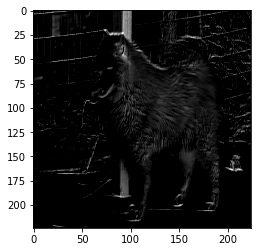

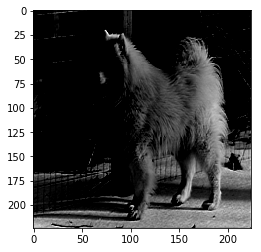

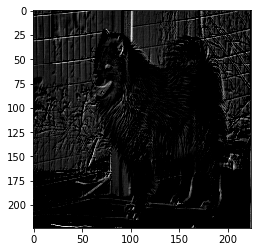

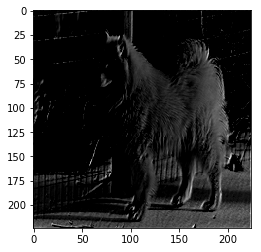

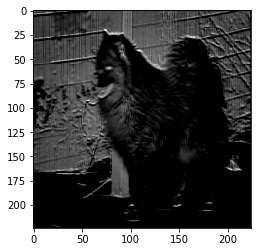

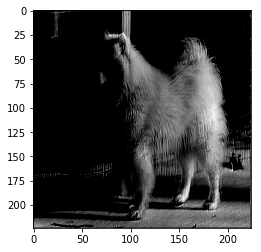

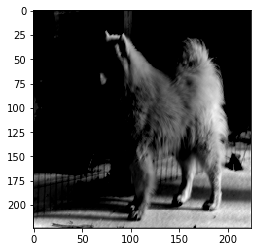

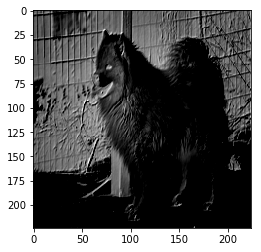

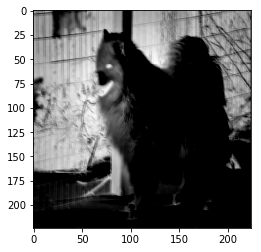

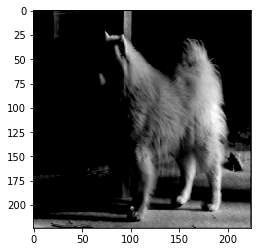

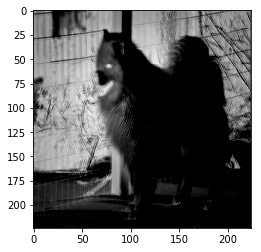

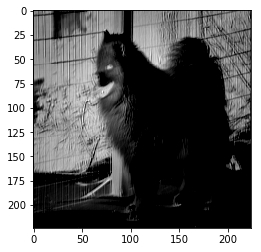

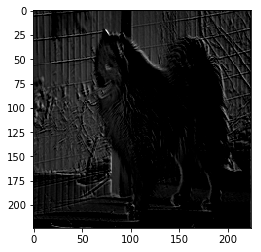

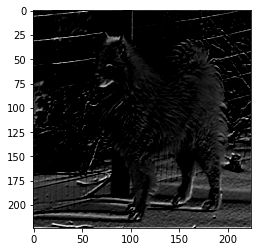

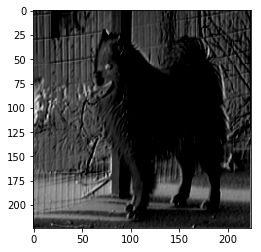

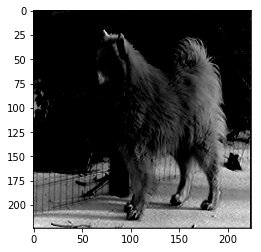

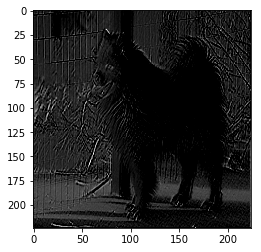

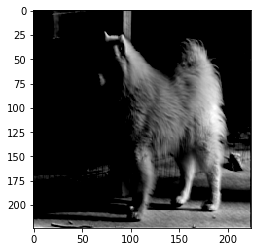

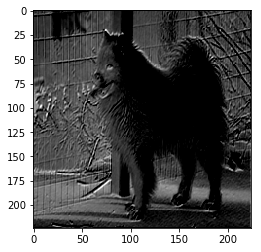

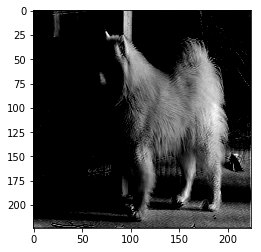

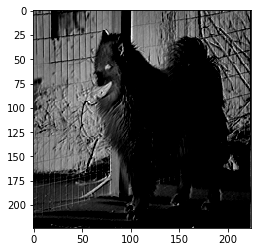

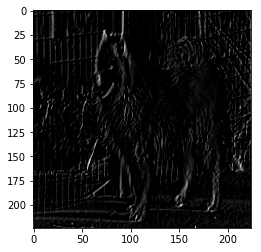

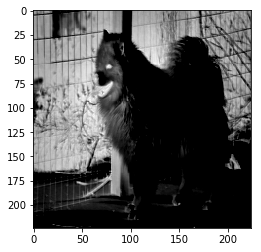

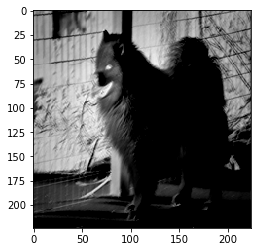

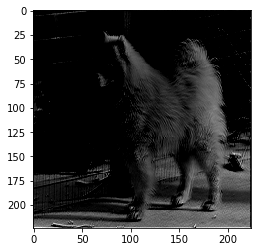

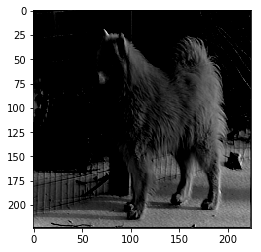

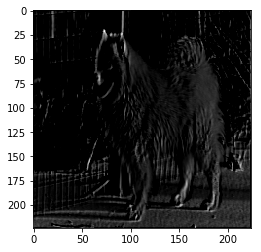

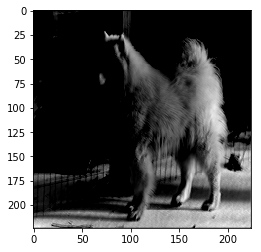

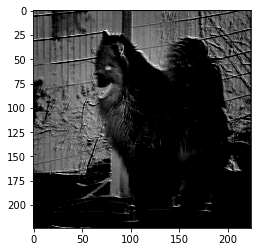

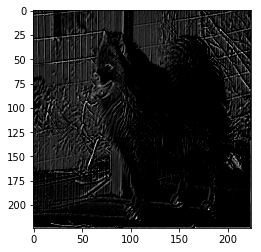

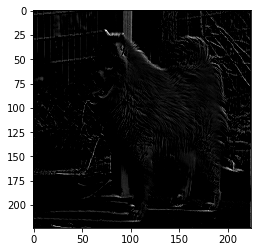

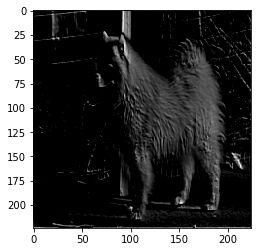

In [60]:
# Un-comment below if you want to visualize
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# test.run(tf.global_variables_initializer())
filteredImage = sess.run(conv1_1, feed_dict={X: image.reshape(1,224,224,3)})
for i in range(32):
    plt.imshow(filteredImage[:,:,:,i].reshape(224,224), cmap='gray')
    plt.show()

random하게 초기화된 weight(filter)가 edge detector로 역할하는 것을 볼 수 있다. 

다음 conv layer을 통과시켜주자.

In [61]:
# CONVOLUTION 1 - 2
with tf.name_scope('conv1_2'):
    filter1_2 = tf.Variable(tf.truncated_normal([3, 3, 32, 32], dtype=tf.float32,
                                                stddev=1e-1), name='weights1_2')
    conv = tf.nn.conv2d(conv1_1, filter1_2, [1,1,1,1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                         trainable=True, name='biases1_2')
    out = tf.nn.bias_add(conv, biases)
    conv1_2 = tf.nn.relu(out)

pooling을 해준다.

In [62]:
# POOL 1
with tf.name_scope('pool1'):
    pool1_1 = tf.nn.max_pool(conv1_2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             name='pool1_1')
    pool1_1_drop = tf.nn.dropout(pool1_1, keepRate1)

2개의 conv layer와 1개의 pooling layer를 지난다.

In [63]:
# CONVOLUTION 2 - 1
with tf.name_scope('conv2_1'):
    filter2_1 = tf.Variable(tf.truncated_normal([3, 3, 32, 64], dtype=tf.float32,
                                                stddev=1e-1), name='weights2_1')
    conv = tf.nn.conv2d(pool1_1_drop, filter2_1, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases2_1')
    out = tf.nn.bias_add(conv, biases)
    conv2_1 = tf.nn.relu(out)
    
# CONVOLUTION 2 - 2
with tf.name_scope('conv2_2'):
    filter2_2 = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                stddev=1e-1), name='weights2_2')
    conv = tf.nn.conv2d(conv2_1, filter2_2, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases2_2')
    out = tf.nn.bias_add(conv, biases)
    conv2_2 = tf.nn.relu(out)
    
# POOL 2
with tf.name_scope('pool2'):
    pool2_1 = tf.nn.max_pool(conv2_2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             name='pool2_1')
    pool2_1_drop = tf.nn.dropout(pool2_1, keepRate1)


마지막 conv layer를 지났을 때 image가 어떤 모습인지 살펴보자.

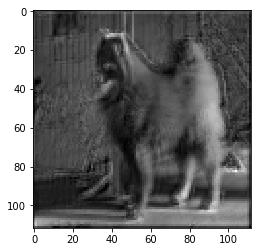

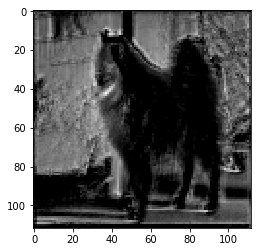

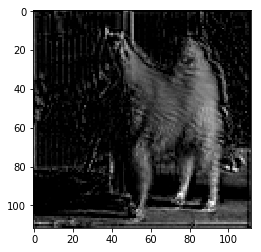

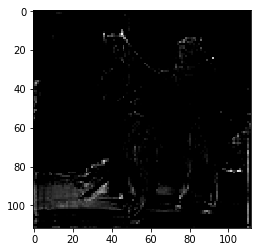

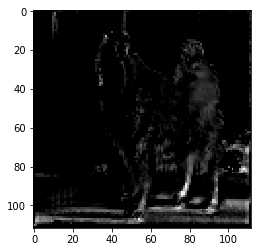

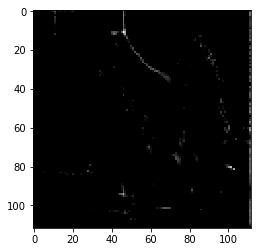

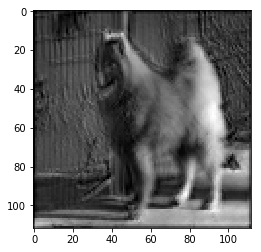

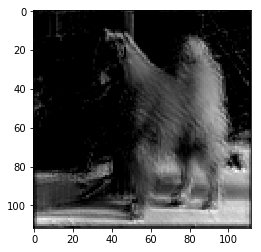

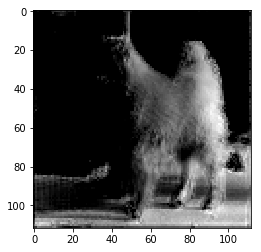

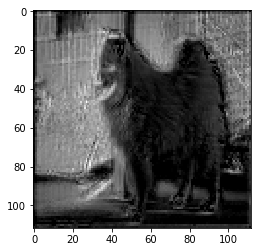

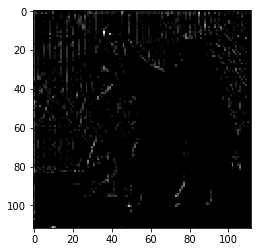

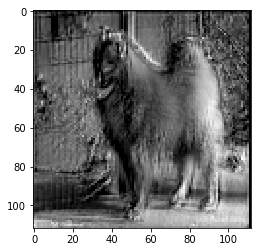

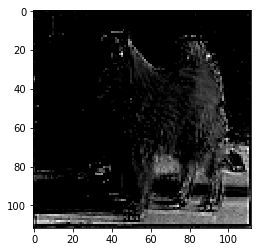

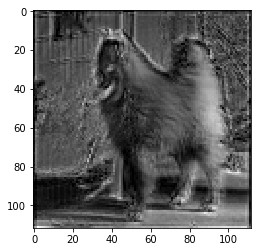

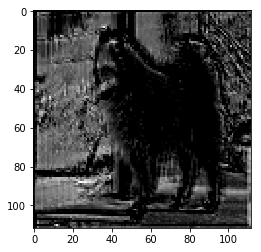

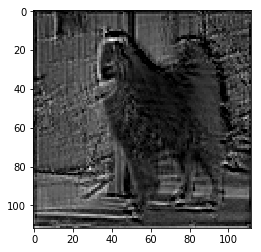

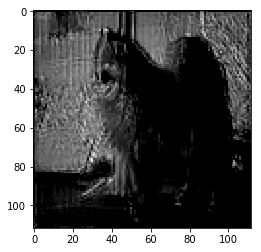

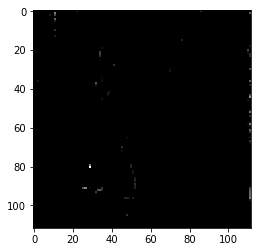

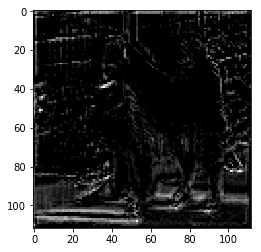

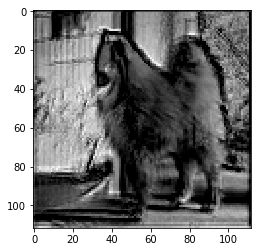

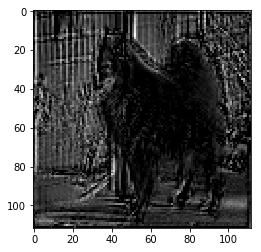

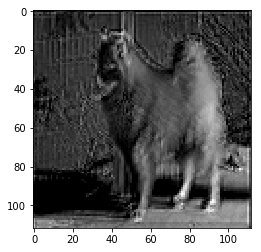

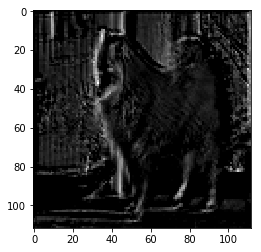

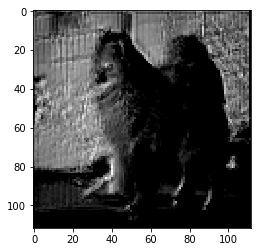

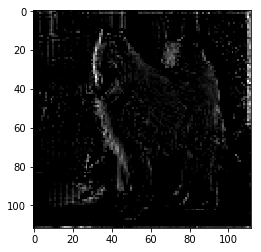

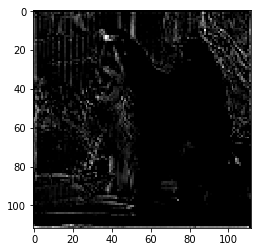

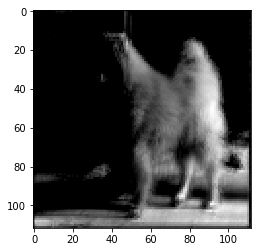

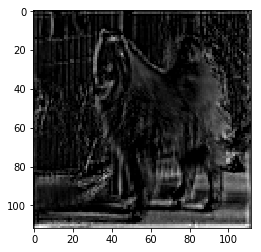

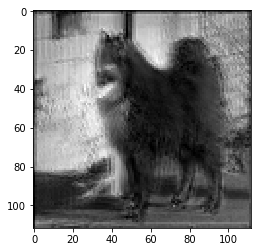

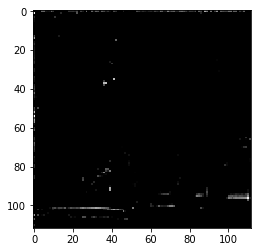

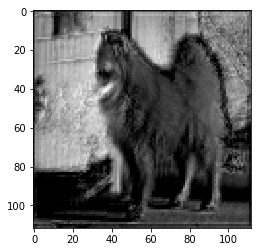

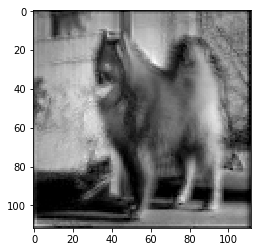

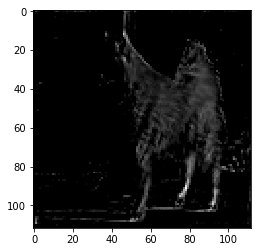

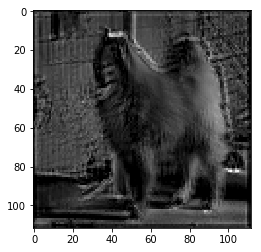

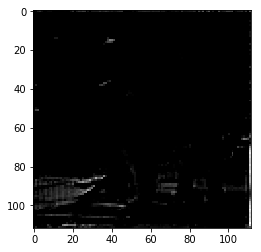

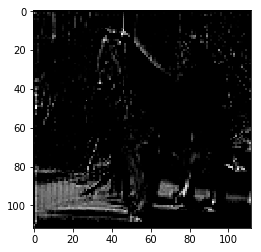

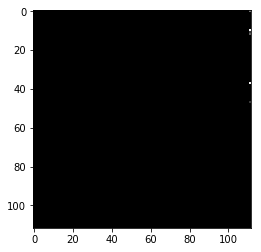

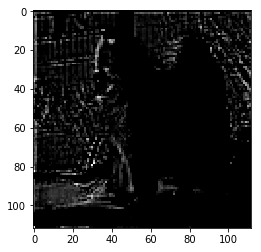

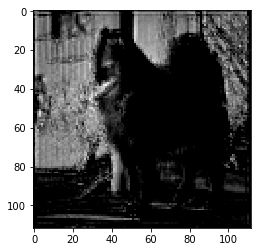

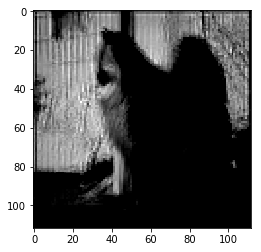

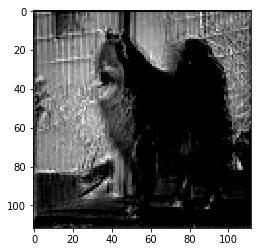

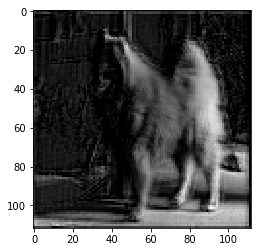

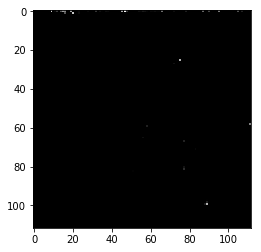

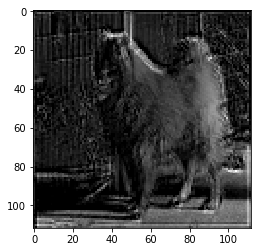

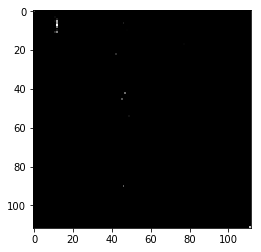

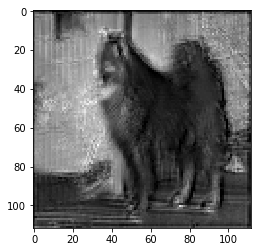

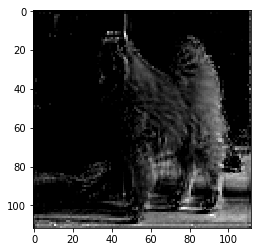

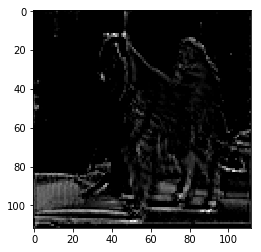

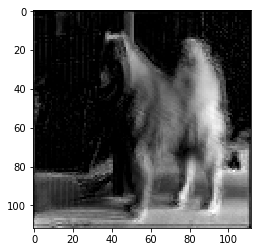

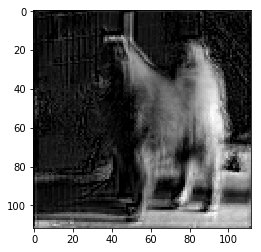

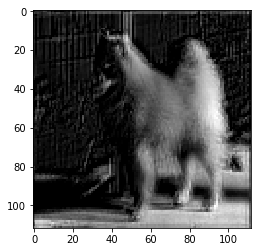

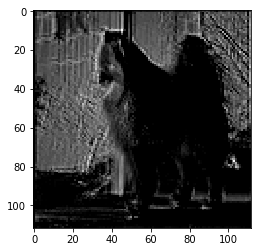

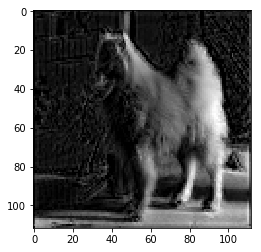

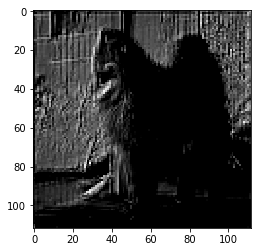

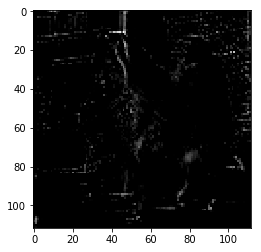

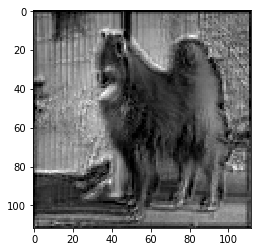

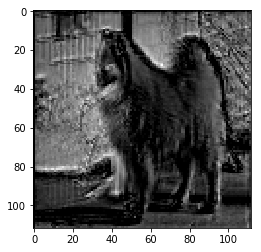

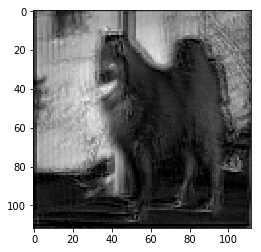

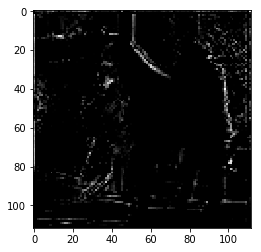

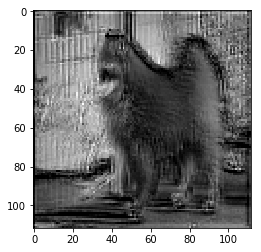

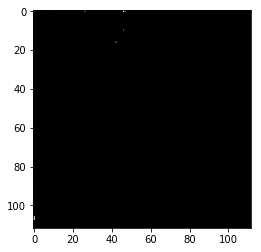

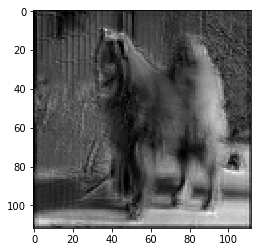

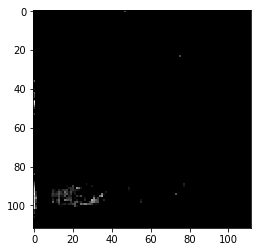

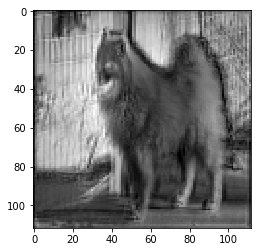

In [64]:
# Un-comment below if you want to visualize

sess = tf.Session()
sess.run(tf.global_variables_initializer())
filteredImage = sess.run(conv2_2, feed_dict={X: image.reshape(1,224,224,3), keepRate1: 1})
for i in range(64):
    plt.imshow(filteredImage[:,:,:,i].reshape(112,112), cmap='gray')
    plt.show()

마지막 정보를 일렬로 만들어서 FC layer에 사용할 수 있도록 한다. 

In [65]:
#FULLY CONNECTED 1
with tf.name_scope('fc1') as scope:
    shape = int(np.prod(pool2_1_drop.get_shape()[1:]))
    fc1w = tf.Variable(tf.truncated_normal([shape, 512], dtype=tf.float32,
                                           stddev=1e-1), name='weights3_1')
    fc1b = tf.Variable(tf.constant(1.0, shape=[512], dtype=tf.float32),
                       trainable=True, name='biases3_1')
    pool2_flat = tf.reshape(pool2_1_drop, [-1, shape])
    out = tf.nn.bias_add(tf.matmul(pool2_flat, fc1w), fc1b)
    fc1 = tf.nn.relu(out)
    fc1_drop = tf.nn.dropout(fc1, keepRate2)

FC layer에서 나온 값을 바탕으로 예측 class값을 구한다.

In [66]:
#FULLY CONNECTED 3 & SOFTMAX OUTPUT
with tf.name_scope('softmax') as scope:
    fc2w = tf.Variable(tf.truncated_normal([512, classes], dtype=tf.float32,
                                           stddev=1e-1), name='weights3_2')
    fc2b = tf.Variable(tf.constant(1.0, shape=[classes], dtype=tf.float32),
                       trainable=True, name='biases3_2')
    Ylogits = tf.nn.bias_add(tf.matmul(fc1_drop, fc2w), fc2b)
    Y = tf.nn.softmax(Ylogits)

hyperparamter를 정해준다.

In [67]:
numEpochs = 400
batchSize = 10
alpha = 1e-4

loss, accuracy, train_op를 정해준다.

In [68]:
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
    loss = tf.reduce_mean(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)


Session을 열고 변수를 초기화해준다.

In [69]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

tensorboard를 만들어서 학습이 잘 되고 있는지 모니터링하자.
매 5 step마다 summary를 구해서 tensorboard에 추가한다. <br>

확인을 위해서는 cmd창에 tensorboard --logdir=/tmp/cnn/ 을 입력하면 된다.

In [70]:
writer_1 = tf.summary.FileWriter("/tmp/cnn/train")
writer_2 = tf.summary.FileWriter("/tmp/cnn/test")
writer_1.add_graph(sess.graph)
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
tf.summary.histogram("weights1_1", filter1_1)
write_op = tf.summary.merge_all()

In [71]:
steps = int(train_x.shape[0]/batchSize)

for i in range(numEpochs):
    accHist = []
    accHist2 = []
    train_x, train_y = imf.shuffle(train_x, train_y)
    for ii in range(steps):
        #Calculate our current step
        step = i * steps + ii
        #Feed forward batch of train images into graph and log accuracy
        acc = sess.run([accuracy], feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
        accHist.append(acc)
        
        if step % 5 == 0:
            # Get Train Summary for one batch and add summary to TensorBoard
            summary = sess.run(write_op, feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
            writer_1.add_summary(summary, step)
            writer_1.flush()
            
            # Get Test Summary on random 10 test images and add summary to TensorBoard
            test_x, test_y = imf.shuffle(test_x, test_y)
            summary = sess.run(write_op, feed_dict={X: test_x[0:10,:,:,:], Y_: test_y[0:10], keepRate1: 1, keepRate2: 1})
            writer_2.add_summary(summary, step)
            writer_2.flush()

        #Back propigate using adam optimizer to update weights and biases.
        sess.run(train_step, feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 0.2, keepRate2: 0.5})
    
    print('Epoch number {} Training Accuracy: {}'.format(i+1, np.mean(accHist)))
    
    #Feed forward all test images into graph and log accuracy
    for iii in range(int(test_x.shape[0]/batchSize)):
        acc = sess.run(accuracy, feed_dict={X: test_x[(iii*batchSize):((iii+1)*batchSize),:,:,:], Y_: test_y[(iii*batchSize):((iii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
        accHist2.append(acc)
    print("Test Set Accuracy: {}".format(np.mean(accHist2)))
    
    
        

Epoch number 1 Training Accuracy: 0.44117647409439087
Test Set Accuracy: 0.4833333492279053
Epoch number 2 Training Accuracy: 0.46764707565307617
Test Set Accuracy: 0.4833333492279053
Epoch number 3 Training Accuracy: 0.49705880880355835
Test Set Accuracy: 0.4833333194255829
Epoch number 4 Training Accuracy: 0.4911764860153198
Test Set Accuracy: 0.4833333492279053
Epoch number 5 Training Accuracy: 0.49705880880355835
Test Set Accuracy: 0.4833333492279053
Epoch number 6 Training Accuracy: 0.5
Test Set Accuracy: 0.4833333492279053
Epoch number 7 Training Accuracy: 0.5029411911964417
Test Set Accuracy: 0.5166667103767395
Epoch number 8 Training Accuracy: 0.520588219165802
Test Set Accuracy: 0.5166667103767395
Epoch number 9 Training Accuracy: 0.5117647051811218
Test Set Accuracy: 0.4999999701976776
Epoch number 10 Training Accuracy: 0.5235294699668884
Test Set Accuracy: 0.5166666507720947
Epoch number 11 Training Accuracy: 0.5647058486938477
Test Set Accuracy: 0.5166666507720947
Epoch num

Test Set Accuracy: 0.8166666626930237
Epoch number 92 Training Accuracy: 0.8088235855102539
Test Set Accuracy: 0.8166666030883789
Epoch number 93 Training Accuracy: 0.8088234066963196
Test Set Accuracy: 0.8333333134651184
Epoch number 94 Training Accuracy: 0.8088235259056091
Test Set Accuracy: 0.833333432674408
Epoch number 95 Training Accuracy: 0.8235294222831726
Test Set Accuracy: 0.8333333134651184
Epoch number 96 Training Accuracy: 0.8147059082984924
Test Set Accuracy: 0.8333333134651184
Epoch number 97 Training Accuracy: 0.8176470994949341
Test Set Accuracy: 0.833333432674408
Epoch number 98 Training Accuracy: 0.8205882906913757
Test Set Accuracy: 0.8333332538604736
Epoch number 99 Training Accuracy: 0.8235294222831726
Test Set Accuracy: 0.8333333134651184
Epoch number 100 Training Accuracy: 0.8088235259056091
Test Set Accuracy: 0.8333333134651184
Epoch number 101 Training Accuracy: 0.8205882906913757
Test Set Accuracy: 0.8499999642372131
Epoch number 102 Training Accuracy: 0.8205

Epoch number 180 Training Accuracy: 0.8647058010101318
Test Set Accuracy: 0.8333333134651184
Epoch number 181 Training Accuracy: 0.8705882430076599
Test Set Accuracy: 0.8166666626930237
Epoch number 182 Training Accuracy: 0.8705881237983704
Test Set Accuracy: 0.8333333134651184
Epoch number 183 Training Accuracy: 0.8647058010101318
Test Set Accuracy: 0.8500000834465027
Epoch number 184 Training Accuracy: 0.8529411554336548
Test Set Accuracy: 0.8333333134651184
Epoch number 185 Training Accuracy: 0.8558822870254517
Test Set Accuracy: 0.8499999642372131
Epoch number 186 Training Accuracy: 0.8558823466300964
Test Set Accuracy: 0.8333333134651184
Epoch number 187 Training Accuracy: 0.8470587730407715
Test Set Accuracy: 0.8333333134651184
Epoch number 188 Training Accuracy: 0.85294109582901
Test Set Accuracy: 0.8333333134651184
Epoch number 189 Training Accuracy: 0.8470588326454163
Test Set Accuracy: 0.8333333134651184
Epoch number 190 Training Accuracy: 0.8705881834030151
Test Set Accuracy

Test Set Accuracy: 0.8500000834465027
Epoch number 269 Training Accuracy: 0.8794117569923401
Test Set Accuracy: 0.8333333134651184
Epoch number 270 Training Accuracy: 0.8676470518112183
Test Set Accuracy: 0.8333333134651184
Epoch number 271 Training Accuracy: 0.8764706254005432
Test Set Accuracy: 0.8333333134651184
Epoch number 272 Training Accuracy: 0.882352888584137
Test Set Accuracy: 0.833333432674408
Epoch number 273 Training Accuracy: 0.8852940797805786
Test Set Accuracy: 0.8333333134651184
Epoch number 274 Training Accuracy: 0.8647058606147766
Test Set Accuracy: 0.8166666626930237
Epoch number 275 Training Accuracy: 0.8558823466300964
Test Set Accuracy: 0.8166666626930237
Epoch number 276 Training Accuracy: 0.8558823466300964
Test Set Accuracy: 0.8166666626930237
Epoch number 277 Training Accuracy: 0.8588234782218933
Test Set Accuracy: 0.8333333134651184
Epoch number 278 Training Accuracy: 0.8647058606147766
Test Set Accuracy: 0.8500000834465027
Epoch number 279 Training Accuracy

Epoch number 357 Training Accuracy: 0.8970587849617004
Test Set Accuracy: 0.8333333134651184
Epoch number 358 Training Accuracy: 0.8823529481887817
Test Set Accuracy: 0.8333333134651184
Epoch number 359 Training Accuracy: 0.8882352709770203
Test Set Accuracy: 0.8166667819023132
Epoch number 360 Training Accuracy: 0.882352888584137
Test Set Accuracy: 0.8166666030883789
Epoch number 361 Training Accuracy: 0.8882352709770203
Test Set Accuracy: 0.8166666030883789
Epoch number 362 Training Accuracy: 0.8911765217781067
Test Set Accuracy: 0.8166666030883789
Epoch number 363 Training Accuracy: 0.8852941393852234
Test Set Accuracy: 0.833333432674408
Epoch number 364 Training Accuracy: 0.8852940797805786
Test Set Accuracy: 0.8166666626930237
Epoch number 365 Training Accuracy: 0.8852941393852234
Test Set Accuracy: 0.8166666626930237
Epoch number 366 Training Accuracy: 0.8941176533699036
Test Set Accuracy: 0.8333333134651184
Epoch number 367 Training Accuracy: 0.8970588445663452
Test Set Accuracy

아래 이미지는 conv1_2의 2개 filter를 지나는 이미지를 매 50 training step 학습에 따라 연속적으로 표현한 결과이다. 

<img src="imageFiles/conv1.gif">

아래 이미지는 conv2_2를 위와 같이 표현해놓은 것이며 학습이 됨에 따라서 좀 더 edge에 focus를 해서 보는 경향이 있는 것을 알 수 있다. 그리고 1번째 filter의 경우에는 많이 변하지 않는데 그 만큼 처음 초기 값 설정이 잘 되었다는 의미이다.

<img src="imageFiles/conv2.gif">

In [26]:
sess.close()